#### **Subgraph** 
Graph that is used as a node in another graph.

Subgraphs are useful for : 
1. Reusability
2. Modularity
3. Maintainability 

Subgraph implements : 
1. Failure isolation 
2. State separation 
3. Observability 

There are two ways in which parent graph and subgraph can communicate : 

1. **Invoke a Graph from a node** — subgraphs are called from inside a node in the parent graph

2. **Add graph as a node** — a subgraph is added directly as a node in the parent and shares state keys with the parent

### **Invoke subgraph inside node of another graph**

- Subgraph schema can be different (no shared keys)
- Define a node function that invokes subgraph 
- This function need to transform input (parent) state to subgraph state before invoking the subgraph 
- transform the results back to the parent state before returning the state update from the node.

--- 

## What are we doing to make : 

A workflow in which if we pass a general question to LLM then it returns answer in english and then (subgraph will translate it to hindi)

### **Subgraph**

In [1]:
## llm used 
from langchain_ollama import ChatOllama 

llm = ChatOllama(
    model='llama3.2',
    verbose=True,
    temperature=0.2
)

print(llm.invoke("Hey How are you?"))

content="I'm just a language model, so I don't have emotions or feelings like humans do. However, I'm functioning properly and ready to help with any questions or tasks you may have! How can I assist you today?" additional_kwargs={} response_metadata={'model': 'llama3.2', 'created_at': '2026-01-17T03:27:39.926042Z', 'done': True, 'done_reason': 'stop', 'total_duration': 22286446166, 'load_duration': 2094019375, 'prompt_eval_count': 30, 'prompt_eval_duration': 17839027625, 'eval_count': 46, 'eval_duration': 2349957083, 'logprobs': None, 'model_name': 'llama3.2', 'model_provider': 'ollama'} id='lc_run--019bc9fe-3050-7ca2-9e25-c96297888af2-0' tool_calls=[] invalid_tool_calls=[] usage_metadata={'input_tokens': 30, 'output_tokens': 46, 'total_tokens': 76}


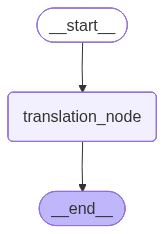

In [4]:
from langgraph.graph import StateGraph, START, END 
from typing import TypedDict, Annotated 
from langchain_core.prompts import PromptTemplate

class SubState(TypedDict):
    input_text: str 
    translated_text: str  

# Subgraph node for translation 
def translated_text(state: SubState):
    template = """ 
        Translate the following text to Hindi. 
        Keep it natural and clear. Do not add extra content.

        Text : {text}
    """

    prompt = PromptTemplate(
        template=template,
        input_variables=['text']
    )

    chain = prompt | llm 
    response = chain.invoke({'text' : state['input_text']})
    return {
        'translated_text' : response
    }

# initiate graph
graph = StateGraph(SubState)

# add node 
graph.add_node('translation_node', translated_text)

# add edge 
graph.add_edge(START, 'translation_node')
graph.add_edge('translation_node', END)

translation_graph = graph.compile()

# display the graph 
from IPython.display import Image 
Image(translation_graph.get_graph().draw_mermaid_png())

#### **Parent Graph**

In [5]:
# state for parent graph 
class ParentState(TypedDict):
    question: str 
    answer_eng: str 
    answer_hin: str 

# making nodes 
# Node 1 - that will answer the question 
def generate_answer(state: ParentState):

    answer = llm.invoke(f"You are a helpful assistant. Answer clearly.\n\nQuestion: {state['question']}").content
    return {'answer_eng': answer}

# Node 2 - invoke the translation graph 
def translate(state: ParentState):
    # call subgraph 
    response = translation_graph.invoke({'input_text' : state['answer_eng']})
    return {
        'answer_hin' : response['translated_text']
    }

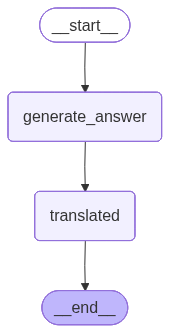

In [6]:
# make the parent graph 
parent_graph = StateGraph(ParentState)

# add nodes 
parent_graph.add_node('generate_answer', generate_answer)
parent_graph.add_node('translated', translate)

# add edges 
parent_graph.add_edge(START, 'generate_answer')
parent_graph.add_edge('generate_answer', 'translated')
parent_graph.add_edge('translated', END)

# compile the graph 
chatbot = parent_graph.compile()

# display the graph 
from IPython.display import Image 
Image(chatbot.get_graph().draw_mermaid_png())

In [7]:
input_state = {'question' : "Hey How are you?"}

output_state = chatbot.invoke(input_state)

In [8]:
from pprint import pprint 
pprint(output_state)

{'answer_eng': "I'm just a language model, so I don't have emotions or "
               "feelings like humans do, but I'm functioning properly and "
               'ready to help! How can I assist you today?',
 'answer_hin': AIMessage(content='मैं बस एक भाषा मॉडल हूँ, इसलिए मुझे मानवों जैसी भावनाएँ या भावनाएँ नहीं हैं, लेकिन मैं ठीक से काम कर रहा हूँ और आपकी मदद करने तैयार हूँ! आज आपको मेरी सहायता कैसे कर सकता हूँ?', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2026-01-17T04:05:42.107856Z', 'done': True, 'done_reason': 'stop', 'total_duration': 4207748542, 'load_duration': 209697708, 'prompt_eval_count': 88, 'prompt_eval_duration': 405746500, 'eval_count': 85, 'eval_duration': 3588781958, 'logprobs': None, 'model_name': 'llama3.2', 'model_provider': 'ollama'}, id='lc_run--019bca21-49e2-76e3-aa98-69291bcf15ea-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 88, 'output_tokens': 85, 'total_tokens': 173}),
 'question': 'Hey How are 